In [2]:
from sklearn import cluster
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
user='S'

if user=='S':
    mandat_dep=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/liste_mandat.csv")#on récupère le csv de la liste des mandats
    df_depu=pd.read_csv("C:/Users/sylva/Desktop/git/Projet-Python-deputes/listeDepute_complete.csv")

if user=='G':
    mandat_dep=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/liste_mandatdef.csv") 
    df_depu=pd.read_csv("C:/Users/Administrateur.LAPTOP-FH8TB47B/Desktop/Projet_assemblee/listeDepute_complete.csv")

Essayons de faire un clustering sur les département selon leur orientation politique sous la troisième république

In [98]:
mandat_dep_3=mandat_dep[mandat_dep['Régime politique']=='Troisième République - Chambre des députés']
liste_groupe_3=mandat_dep_3['Groupe'].unique()
gros_groupe=[]
for groupe in liste_groupe_3 :
    if mandat_dep_3[mandat_dep_3['Groupe']==groupe]['Groupe'].count()>10 :
        gros_groupe+=[groupe]#on va se concentrer sur les gros groupes pour diminuer la complexité
datadep=[]
for departement in mandat_dep_3['Département'].unique():
    newdep=[]
    dep_3=mandat_dep_3[mandat_dep_3['Département']==departement]
    nbremand=dep_3['Groupe'].count()
    for groupe in gros_groupe :
        pct_groupe=dep_3[dep_3['Groupe']==groupe]['Groupe'].count()/nbremand
        newdep+=[pct_groupe]
    datadep+=[newdep]
datadep_bis=np.array(datadep)#on crée un dataframe avec les informations
depmt_groupe = pd.DataFrame(datadep_bis, index=mandat_dep_3['Département'].unique(),columns=gros_groupe)
    

In [32]:
depmt_groupe = pd.DataFrame(datadep_bis, index=mandat_dep_3['Département'].unique(),columns=gros_groupe)

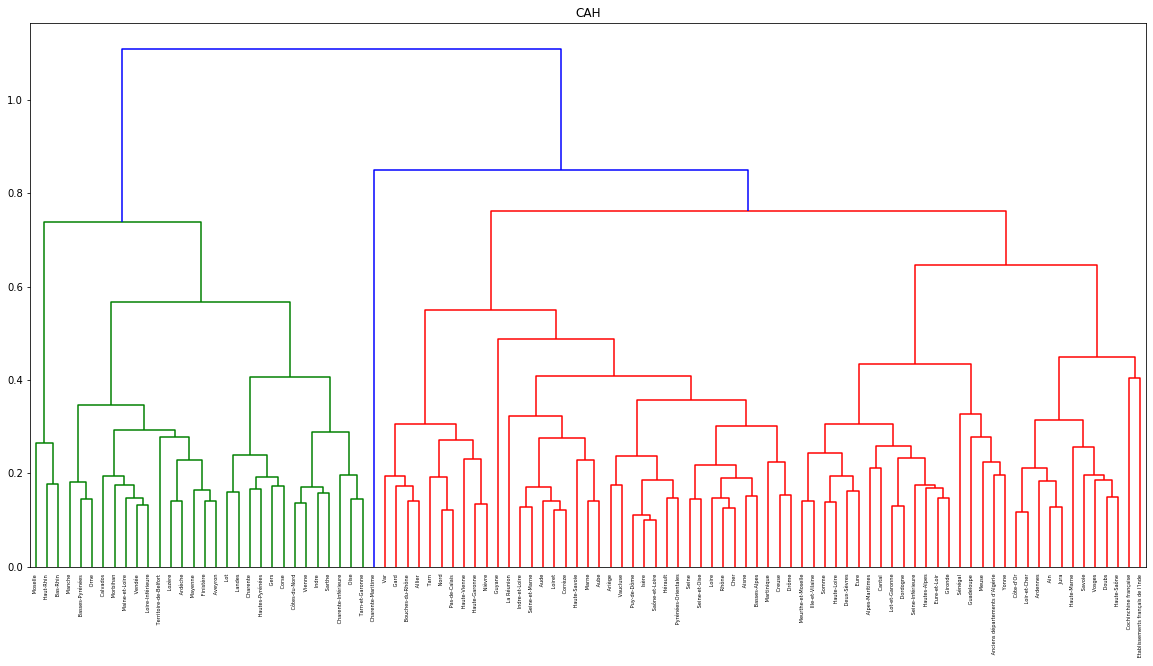

In [97]:
plt.figure(figsize=(20,10))
#générer la matrice des liens

Z = linkage(depmt_groupe,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=depmt_groupe.index)
plt.show()


In [93]:

kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(depmt_groupe)
idk = np.argsort(kmeans.labels_)#on trie les index
#affichage des observations et leurs groupes
clusters=pd.DataFrame(kmeans.labels_[idk], depmt_groupe.index[idk], columns=['Appartenance'])
clusters
depmt_app=depmt_groupe.merge(clusters, right_index=True, left_index=True)
#distances aux centres de classes des observations
dist_centre=kmeans.transform(depmt_groupe)
#print(dist_centre)
dist_centre.mean()#les départements sont en moyenne plus proches d'un centre que de l'autre


0.2153585591153429

In [94]:
#récupération d'une carte des départements français
import requests
import tempfile
import zipfile
temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname =temporary_location, destname = "borders"):#fonction qui dézippe
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref: 
        zip_ref.extractall(dirname + '/' + destname)
download_unzip('https://www.data.gouv.fr/fr/datasets/r/3096e551-c68d-40ce-8972-a228c94c0ad1')#l'URL où on trouve les départements
carte_departement = gpd.read_file(tempfile.gettempdir() + "/borders/departements-20140306-100m.dbf")#on va chercher le fichier là où on l'a stocké
carte_metrop = carte_departement.loc[0:95]#on enlève les départements d'outre-mer pour avoir une carte lisible
carte_metrop.set_index('nom', inplace=True)#on met le nom du département en index pour pouvoir joindre les bases

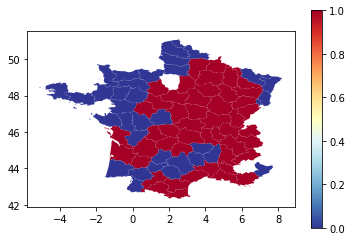

In [96]:
depmt_app.index=[i[1:] for i in depmt_app.index]#on enlève l'espace devant le nom des départements

df = carte_metrop.merge(depmt_app, how = 'inner', left_index=True, right_index=True)
df.plot(column = 'Appartenance', cmap = 'RdYlBu_r', legend=True)#on crée des cartes